# Humpback Whale Identification -- DTSA 5511 Final Project

## Step 1: Brief description of the problem and data

This is the final project for DTSA 5511 (Introduction to Deep Learning). And It is about Humpback Whale Identification.

The data comes from a [Kaggle](https://www.kaggle.com/c/humpback-whale-identification) competition. This dataset contains over 25,000 images of humpback whale flukes in the training set, each linked to a unique identifier (Id) assigned by researchers. Additionally, the test set comprises approximately 8,000 images for which the corresponding IDs need to be predicted. 

The main objective is to accurately predict the whale ID for images in the test set by analyzing the visual characteristics of the flukes. This task requires the application of machine learning techniques to identify patterns that differentiate individual whales, allowing the model to generalize its predictions to unseen data. Successful identification of whale IDs not only aids marine research but also deepens our understanding of humpback whale populations and their behaviors. Additionally, any whales in the test dataset that do not match the IDs in the training data will be classified as new_whale, ensuring that the model can effectively handle previously unencountered individuals.

## Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

This dataset includes a training set of 25,361 whale images with labeled IDs, as well as a test set of 7,960 whale images for which the IDs need to be predicted.

In [1]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict

In [2]:
df = pd.read_csv("data/train.csv")

In [3]:
df

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
...,...,...
25356,ffef89eed.jpg,w_9c506f6
25357,fff7faf61.jpg,w_9cf0388
25358,fff9002e0.jpg,w_bd1c3d5
25359,fffcde6fe.jpg,w_9f30885


### 1. Visualizing the images and labels

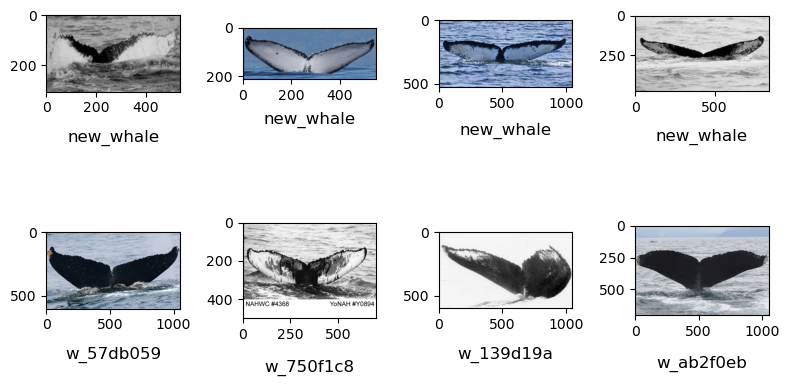

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(8,5))
idx = 0
for _,r in df.sample(n=8, random_state=111).iterrows():
    im = cv2.imread("data/train/%s" %(r["Image"]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax_row, ax_col = idx // 4, idx % 4
    ax[ax_row, ax_col].imshow(im)
    ax[ax_row, ax_col].set_title(r["Id"], y=-0.2, pad=-25)
    idx += 1
plt.tight_layout()

These images are about whale flukes, but their quality, size, dimensions and color vary significantly. Some images even contain handwritten information. In addition, images labeled `new_whale` correspond to different whales, and we need to take this into account during data preprocessing.

### 2. Data distribution

In [5]:
df_img_count = df.groupby("Id").size().reset_index(name="img_count")
df_img_count = df_img_count.sort_values(by="img_count", ascending=False).reset_index(drop=True)
df_img_count.head()

,Id,img_count
0,new_whale,9664
1,w_23a388d,73
2,w_9b5109b,65
3,w_9c506f6,62
4,w_0369a5c,61


Out of the 25,361 images in the training set, 9,664 (over 38%) are labeled as `new_whale`! As previously mentioned, these images correspond to different whales.

Let’s look at the distribution of the remaining 62% of the data (excluding `new_whale`).

Text(0.5, 1.0, "Top 25 id's with the most number of images (excl. new_whale)")

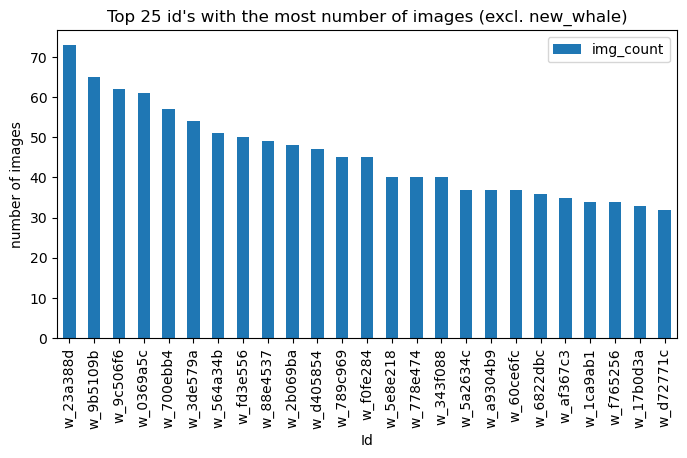

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
df_img_count.iloc[1:1+25].plot.bar(x="Id", y="img_count", ax=ax)
ax.set_ylabel("number of images")
ax.set_title("Top 25 id's with the most number of images (excl. new_whale)")

Text(0.5, 1.0, "Distribution of Whale Id's by Image Count")

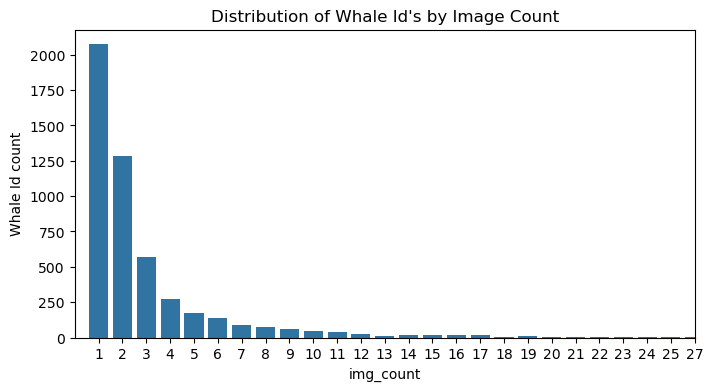

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.countplot(data=df_img_count.iloc[1:], x="img_count", ax=ax)
ax.set_xlim([-1, 25])
ax.set_ylabel("Whale Id count")
ax.set_title("Distribution of Whale Id's by Image Count")

The whale with the largest number of images has more than 70, while more than 2,000 whales only have one image, making the data extremely unbalanced.

### 3. Check duplicates

Used ideas from: 
* https://www.kaggle.com/code/kretes/eda-distributions-images-and-no-duplicates#Duplicates

#### - Check duplicates in the train-set

In [8]:
d = defaultdict(list)

In [9]:
hasher = cv2.img_hash.PHash_create()

In [10]:
for index, row in df.iterrows():
    filename = row["Image"]
    im = cv2.imread(f"data/train/{filename}")
    hash_value = hasher.compute(im)[0]
    d[tuple(hash_value)].append((filename, row["Id"]))

In [11]:
duplicates = dict()
for k, v in d.items():
    if len(v)>1:
        duplicates[k] = v
print(len(duplicates))
print(duplicates.values())

1
dict_values([[('60a3f2422.jpg', 'w_7a8ce16'), ('7f7a63b8a.jpg', 'w_7a8ce16')]])


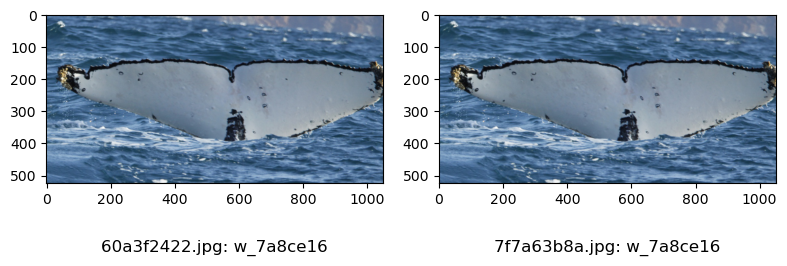

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8,5))

im = cv2.imread("data/train/60a3f2422.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
ax[0].imshow(im) 
ax[0].set_title("60a3f2422.jpg: w_7a8ce16", y=-0.2, pad=-25)

im = cv2.imread("data/train/7f7a63b8a.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
ax[1].imshow(im) 
ax[1].set_title("7f7a63b8a.jpg: w_7a8ce16", y=-0.2, pad=-25)

plt.tight_layout()

Only two files in the train-set have the same image, and they have the same label w_7a8ce16, so it is OK to take both into training.

#### - Check images in the test-set if they are duplicated in the train-set

In [13]:
df_submission = pd.read_csv("data/sample_submission.csv")

for index, row in df_submission.iterrows():
    filename = row["Image"]
    im = cv2.imread(f"data/test/{filename}")
    hash_value = hasher.compute(im)[0]
    if tuple(hash_value) in d: # d contains hash_value found in the train-set
        print(f"data/test/{filename} ==> {d[tuple(hash_value)]}")

data/test/fb3879dc7.jpg ==> [('b95d73a55.jpg', 'w_691f2f6')]


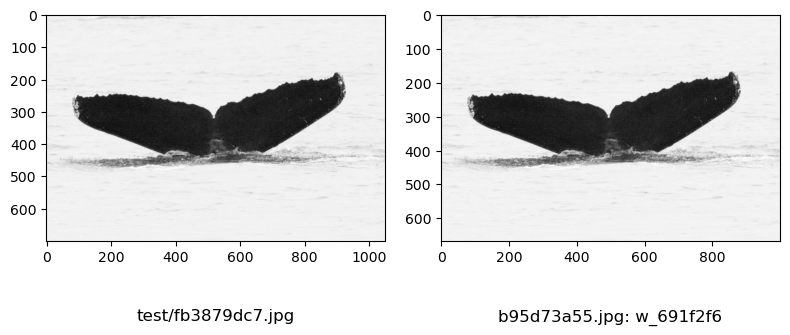

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8,5))

im = cv2.imread("data/test/fb3879dc7.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
ax[0].imshow(im) 
ax[0].set_title("test/fb3879dc7.jpg", y=-0.2, pad=-25)

im = cv2.imread("data/train/b95d73a55.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
ax[1].imshow(im) 
ax[1].set_title("b95d73a55.jpg: w_691f2f6", y=-0.2, pad=-25)

plt.tight_layout()

Only one file in the test set contains an image that is also present in the training set, which can be utilized as a free answer.

### 4. Data preparation: Resizing train and test images to be the same size (i.e. 512x512) 

It is possible to process the image on the fly while training the model, however I found that this significantly slow down the model training, therefore I preprocess the images and save to disk first. During model training, I will read from the disk.

#### - Resizing train set and train-set augmentation

The images are converted to grey-scale, and resized to 512x512 pixels while maintaining their aspect ratio, allowing us to utilize downstream pretrained TensorFlow Keras models.

The reason for converting to grey-scale is because the images come in various color, and unifying all of the images into grey-scale might help the model training. 

I also augment train-set images by randomly applying rotation, translation, and contrast adjustment to Ids with 5 or fewer images in order to mitigate the effects of data imbalance.

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image

In [16]:
df = pd.read_csv("data/train.csv")
print ("Number of total rows: ", len(df))

Number of total rows:  25361


In [17]:
print(df.head())
train_filenames = df["Image"]

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale


In [18]:
IMG_SIZE = 512

def resize_same_ar(image, target_width, target_height):
    # resize image to target_width, target_height by maintaining aspect ratio
    #
    # Get the original dimensions of the image
    original_shape = tf.shape(image)
    original_height = tf.cast(original_shape[0], tf.float32)
    original_width = tf.cast(original_shape[1], tf.float32)
    
    # Calculate the aspect ratios
    aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height

    if aspect_ratio > target_aspect_ratio:
        # Image is wider than target aspect ratio
        new_width = target_width
        new_height = target_width / aspect_ratio
    else:
        # Image is taller than target aspect ratio
        new_height = target_height
        new_width = target_height * aspect_ratio

    # Resize the image
    resized_image = tf.image.resize(image, [tf.cast(new_height, tf.int32), tf.cast(new_width, tf.int32)])

    # Place the resized image in the center of the new image
    # tf.image.resize_with_crop_or_pad always place the image on a (0,0,0) "black" background. 0 is black, 255 is white, 128 is grey
    # Set the background color to be dark-grey ie. 192.
    resized_image = tf.math.add(resized_image, -192)
    new_image = tf.image.resize_with_crop_or_pad(resized_image, tf.cast(target_height, tf.int32), tf.cast(target_width, tf.int32))
    new_image = tf.math.add(new_image, 192)

    return new_image

def process_image(infilepath):
    # resize image to (WxH) 512x512 by maintaining aspect ratio    
    image = tf.io.read_file(infilepath)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    greyscale = tf.image.rgb_to_grayscale(image)
    image = tf.tile(greyscale, [1,1,3])

    # aspect ratio 1:1 for downstream pretrained tf.keras
    target_width_photoId, target_height_photoId = tf.constant(IMG_SIZE, dtype = tf.float32), tf.constant(IMG_SIZE, dtype = tf.float32)
    image_for_photoId = resize_same_ar(image, target_width_photoId, target_height_photoId)

    return image_for_photoId

In [19]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.06), # 0.06 * 360 deg = 21.6 deg 
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

def process_image_augmented(infilepath):
    # resize image to (WxH) 512x512 by maintaining aspect ratio    
    image = tf.io.read_file(infilepath)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    greyscale = tf.image.rgb_to_grayscale(image)
    image = tf.tile(greyscale, [1,1,3])

    # augment image
    image = img_augmentation(image)

    # aspect ratio 1:1 for downstream pretrained tf.keras
    target_width_photoId, target_height_photoId = tf.constant(IMG_SIZE, dtype = tf.float32), tf.constant(IMG_SIZE, dtype = tf.float32)
    image_for_photoId = resize_same_ar(image, target_width_photoId, target_height_photoId)

    return image_for_photoId

In [20]:
train_infilepaths, train_outfilepaths = list(), list()
for x in train_filenames:
    train_infilepaths.append("data/train/%s" %(x))
    train_outfilepaths.append("data/resized_train/%s" %(x))
X_train = tf.data.Dataset.from_tensor_slices((train_infilepaths))

X_train = X_train.map(process_image)

X_ = X_train.take(-1)
for i, img in enumerate(X_):
    outfilepath = train_outfilepaths[i]
    _img = img.numpy()
    _img = _img.astype(np.uint8)
    Image.fromarray(_img).save(outfilepath, "JPEG")

In [21]:
df_count = df.groupby("Id").size().reset_index(name="count")
df_merged = pd.merge(df, df_count, on="Id", how="left")
df_augment = df_merged[df_merged["count"] <= 5].reset_index(drop=True).drop("count", axis = 1)
df_augment.to_csv("data/my_augment.csv", index=False)

print("Number of augmented images (which Id has no more than 5 images): ", len(df_augment))
print("Number of total images in train-set: ", len(df))
print("Number of total images which are not new_whale in train-set: ", len(df[df["Id"]!="new_whale"]))
print("Proportion of augmented images to total images: ", len(df_augment)/len(df))
print("Proportion of augmented images to non new_whale images: ", len(df_augment)/len(df[df["Id"]!="new_whale"]))

Number of augmented images (which Id has no more than 5 images):  8299
Number of total images in train-set:  25361
Number of total images which are not new_whale in train-set:  15697
Proportion of augmented images to total images:  0.3272347304916999
Proportion of augmented images to non new_whale images:  0.5286997515448811


In [22]:
train_filenames = df_augment["Image"]

train_infilepaths, train_outfilepaths = list(), list()
for x in train_filenames:
    train_infilepaths.append("data/train/%s" %(x))
    train_outfilepaths.append("data/resized_train/aug_%s" %(x))
X_train = tf.data.Dataset.from_tensor_slices((train_infilepaths))

X_train = X_train.map(process_image_augmented)

X_ = X_train.take(-1)
for i, img in enumerate(X_):
    outfilepath = train_outfilepaths[i]
    _img = img.numpy()
    _img = _img.astype(np.uint8)
    Image.fromarray(_img).save(outfilepath, "JPEG")

#### - Visualizing processed and augmented images

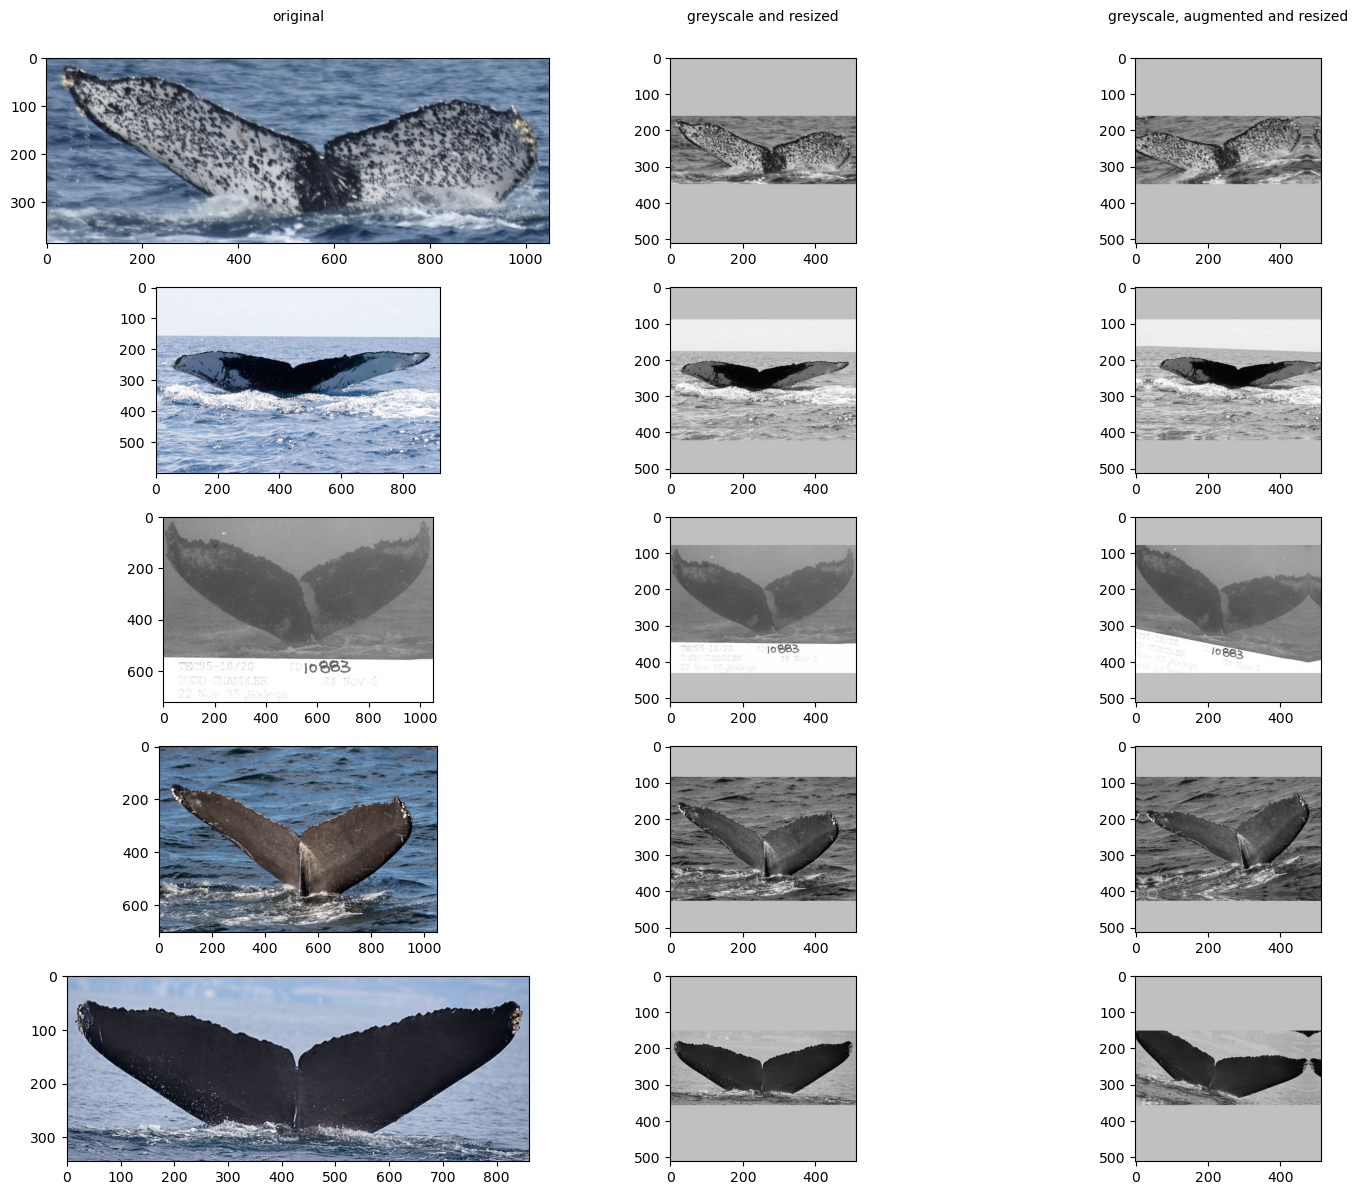

In [23]:
df_sample = df_augment.sample(n=5, ignore_index=True)
train_filenames = df_sample["Image"]

fig, axs = plt.subplots(5, 3, figsize=(15, 12))

for i, f in enumerate(train_filenames):
    infilepath = "data/train/%s" %(f)
    im = cv2.imread(infilepath)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    axs[i, 0].imshow(im)

    infilepath = "data/resized_train/%s" %(f)
    im = cv2.imread(infilepath)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    axs[i, 1].imshow(im)

    infilepath = "data/resized_train/aug_%s" %(f)
    im = cv2.imread(infilepath)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    axs[i, 2].imshow(im)

axs[0,0].text(0.5, 1.2, "original", ha='center', transform=axs[0,0].transAxes)
axs[0,1].text(0.5, 1.2, "greyscale and resized", ha='center', transform=axs[0,1].transAxes)
axs[0,2].text(0.5, 1.2, "greyscale, augmented and resized", ha='center', transform=axs[0,2].transAxes)
plt.tight_layout()

#### - Resizing test set

In [24]:
df = pd.read_csv("data/sample_submission.csv")
print ("Number of total rows: ", len(df))

Number of total rows:  7960


In [25]:
print(df.head())
test_filenames = df["Image"]

           Image                                                 Id
0  00028a005.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
1  000dcf7d8.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
2  000e7c7df.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
3  0019c34f4.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
4  001a4d292.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c


In [26]:
test_infilepaths, test_outfilepaths = list(), list()
for x in test_filenames:
    test_infilepaths.append("data/test/%s" %(x))
    test_outfilepaths.append("data/resized_test/%s" %(x))
X_test = tf.data.Dataset.from_tensor_slices((test_infilepaths))

X_test = X_test.map(process_image)

X_ = X_test.take(-1)
for i, img in enumerate(X_):
    outfilepath = test_outfilepaths[i]
    _img = img.numpy()
    _img = _img.astype(np.uint8)
    Image.fromarray(_img).save(outfilepath, "JPEG")


### 5. Train and Val split

The 38% of images labeled as `new_whale` are excluded from model training. I will later use this `new_whale` dataset to set the logit threshold for categorizing test images as `new_whale`.

I only split the validation set for IDs that had at least 8 images. This way, the training set IDs are completely different.

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
df = pd.read_csv("data/train.csv")
print ("Number of total rows: ", len(df))

Number of total rows:  25361


In [29]:
# save new_whale
df_new_whale = df[df["Id"]=="new_whale"].reset_index(drop=True)
df_new_whale.to_csv("data/my_new_whale.csv", index=False)

# exclude new_whale for photoId model training
df = df[df["Id"]!="new_whale"].reset_index(drop=True)
print("Number of total rows after excluding 'new_whale': ", len(df))

Number of total rows after excluding 'new_whale':  15697


In [30]:
# include augmented images
df1 = df_augment.copy()
df1["Image"] = df1["Image"].map(lambda x: "aug_%s" %(x))
df = pd.concat([df, df1], axis=0, ignore_index=True)

In [31]:
df_count = df.groupby("Id").size().reset_index(name="count")
df_merged = pd.merge(df, df_count, on="Id", how="left")

In [32]:
K = 8
df_count_lt_K = df_merged[df_merged["count"] < K].reset_index(drop=True).drop("count", axis = 1)
df_count_ge_K = df_merged[df_merged["count"] >= K].reset_index(drop=True)

In [33]:
X, y = df_count_ge_K["Image"], df_count_ge_K["Id"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

df_train = pd.concat([X_train, y_train], axis=1, ignore_index=True)
df_train.columns = ["Image", "Id"]
df_val = pd.concat([X_val, y_val], axis=1, ignore_index=True)
df_val.columns = ["Image", "Id"]
df_val = df_val.reset_index(drop=True)

df_train = pd.concat([df_train, df_count_lt_K], axis=0, ignore_index=True)
df_train = df_train.reset_index(drop=True)

print("Nubmer of train set images: ", len(df_train))
df_train.to_csv("data/my_train.csv", index=False)

print("Nubmer of val set images: ", len(df_val))
df_val.to_csv("data/my_val.csv", index=False)

Nubmer of train set images:  21525
Nubmer of val set images:  2471


### Exploratory Data Analysis (EDA) summary

Data imbalance is a significant challenge in this dataset, particularly with the `new_whale` category comprising 38% of the training images. To address this issue, I implemented several methods:

* Augmentation: Approximately 30% of the images belong to whales that have more than five images, with the highest number of images for a single whale being 73. Conversely, around 30% of the images are from whales with fewer than four images, and over 2,000 whales are represented by only one image. I augmented the training images for IDs with five or fewer images by applying random transformations such as rotation, translation, and contrast adjustments. This helps to increase the diversity of the training data and reduces the impact of underrepresented classes. 

* Duplicate Management: There is only one duplicate in the training set, and since both images correspond to the same whale ID, I decided to keep them, as they can be beneficial for training without causing confusion. Additionally, a duplicate was found between the training and test sets, and this known answer can be used to check the accuracy of the model’s predictions.

* Data Preparation: All images were resized to 512x512 pixels and converted to grayscale. The 38% of images labeled as `new_whale` were set aside to prevent them from interfering with the training process. For the remaining images, only those IDs with at least 8 images were split into the training and validation sets, while the others were merged into the training set. This approach ensures a more balanced representation of IDs in the training set, allowing the model to learn from a broader variety of examples.

By employing these strategies, I aim to improve the model's performance and robustness in the face of data imbalance.

## Step 3: Model training

### Model_1: Classification with Center Loss

Use the pretrained ResNet50 model with Center Loss in addition to the standard Categorical Cross Entropy (or Softmax) loss. Center Loss helps to improve the discriminative power of the model by minimizing the distance between the features of the same class while maximizing the distance between features of different classes.

![title](Classification_with_Center_Loss.png)

Keras tutorials:
* https://keras.io/guides/transfer_learning/
* https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Center Loss was recommmended to be added to improve the classification result, vs plain softmax loss:
* https://ducha-aiki.medium.com/thanks-radek-7th-place-solution-to-hwi-2019-competition-738624e4c885


In [1]:
from sklearn.preprocessing import OrdinalEncoder

In [35]:
train_df = pd.read_csv("data/my_train.csv")
val_df = pd.read_csv("data/my_val.csv")

In [36]:
enc = OrdinalEncoder()
enc.fit(np.array(train_df["Id"].values).reshape(-1,1))
NUM_CLASSES = len(enc.categories_[0])
print ("Number of distinct Id: ", NUM_CLASSES)

Number of distinct Id:  5004


In [37]:
train_filenames, train_classes = list(), list()
for i, yi in enumerate(enc.transform(np.array(train_df["Id"].values.reshape(-1,1)) )):
    train_filenames.append("data/resized_train/%s" %(train_df["Image"][i]))
    train_classes.append(int(yi[0]))

X_train = tf.data.Dataset.from_tensor_slices((train_filenames))
y_train = tf.data.Dataset.from_tensor_slices((train_classes))

In [38]:
val_filenames, val_classes = list(), list()
for i, yi in enumerate(enc.transform(np.array(val_df["Id"].values.reshape(-1,1)) )):
    val_filenames.append("data/resized_train/%s" %(val_df["Image"][i]))
    val_classes.append(int(yi[0]))

X_val = tf.data.Dataset.from_tensor_slices((val_filenames))
y_val = tf.data.Dataset.from_tensor_slices((val_classes))

In [39]:
def preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)

    return image

def preprocess_label(classlabel):
    return tf.one_hot(classlabel, NUM_CLASSES)

In [40]:
X_train = X_train.map(preprocess_image)
y_train = y_train.map(preprocess_label)

X_val = X_val.map(preprocess_image)
y_val = y_val.map(preprocess_label)

#### - Function to calculate mAP@5 metric

The Kaggle competition uses Mean Average Precision @5 (MAP@5) to evaluate the submission. So we define a custom function to calculate MAP@5, and use this metric during the validation phase of the model training. 

![title](MAP@5_metric.png)

In [41]:
def mAP_5(y_true, y_pred):
    batch_size = tf.shape(y_true)[0]
    P = tf.constant([[1/1, 1/2, 1/3, 1/4, 1/5]], dtype=tf.float32)
    top_indices = tf.argsort(y_pred, axis= -1, direction='DESCENDING')
    top5_indices = tf.slice(top_indices, begin=[0, 0], size=[batch_size, 5])
    y_rel = tf.gather(y_true, top5_indices, axis=-1, batch_dims=1)
    AP = tf.math.reduce_sum( tf.math.multiply(y_rel, P), axis= -1)
    mAP = tf.math.reduce_mean(AP, axis=0)
    return mAP

#### - Center Loss layer

Reference implementation in Keras:
* https://www.idiap.ch/software/bob/docs/bob/bob.learn.tensorflow/master/_modules/bob/learn/tensorflow/losses/center_loss.html
* https://github.com/EncodeTS/TensorFlow_Center_Loss/blob/master/center_loss.py
* https://github.com/handongfeng/MNIST-center-loss/blob/master/centerLoss_MNIST.py

In [42]:
class CenterLoss(layers.Layer):
    def __init__(self, num_classes, alpha=0.5, loss_multiplier=1.0, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.alpha = alpha
        self.loss_multiplier = loss_multiplier

    def get_config(self):
        config = super().get_config()
        config.update({"num_classes": self.num_classes, "alpha": self.alpha, "loss_multiplier": self.loss_multiplier})
        return config
        
    def build(self, input_shape):
        # x: embeddings or prelogits in bob.learn.tensorflow => (batch_size, nr_embeddings)

        # y_true: is one-hot encoded
        # y_label: label (ie. ordinal-encdoded, not one-hot) => (batch_size, )
        # y_label = tf.math.argmax(y_true, axis=-1, output_type=tf.int32)
        x_shape, y_true_shape = input_shape
        self.centers = self.add_weight(name='centers',
                                       shape=(self.num_classes, x_shape[-1]),
                                       initializer='uniform',
                                       trainable=False)
        super().build(input_shape)

    def call(self, inputs):
        x, y_true = inputs
        y_label = tf.math.argmax(y_true, axis=-1, output_type=tf.int32)

        centers_batch = tf.gather(self.centers, y_label, axis=0)
        center_loss = tf.keras.losses.MeanSquaredError()(centers_batch, x)
        self.add_loss(self.loss_multiplier * center_loss)

        diff = centers_batch - x # (batch_size, nr_embeddings)

        unique_label, unique_idx, unique_count = tf.unique_with_counts(y_label)
        appear_times = tf.gather(unique_count, unique_idx) # (batch_size,)
        appear_times = tf.reshape(appear_times, [-1, 1]) # (batch_size,1)

        diff = diff / tf.cast(appear_times, tf.float32)
        diff = self.alpha * diff

        updates = tf.scatter_nd(y_label[:,None], diff, self.centers.shape)
        self.centers.assign_sub(updates)

        return x

In [43]:
# Center Loss layer
cl_layer = CenterLoss(NUM_CLASSES)

In [44]:
def create_model():
    # Load the resnet50 model without the top layer
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Freeze the base model
    
    # Create the model
    input_images = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    one_hot_labels = layers.Input(shape=(NUM_CLASSES))
    
    x = base_model(input_images)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)  # Dropout for regularization    
    x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(512, activation=None, name="Embeddings")(x)  # Embeddings
    x = cl_layer([x, one_hot_labels])
    x = layers.Activation('relu')(x)
    logits = layers.Dense(NUM_CLASSES)(x)

    model = models.Model(inputs=[input_images, one_hot_labels], outputs=logits, name="ClassificationWithCenterLoss")
    
    # Compile the model
    # use high lr on frozen model
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['top_k_categorical_accuracy', mAP_5])

    return model

model1 = create_model()
print(model1.summary())

Model: "ClassificationWithCenterLoss"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 2048  8192       ['resnet50[0][0]']               
 alization)                     )                                      

In [45]:
BATCH_SIZE = 16

dataset_train = tf.data.Dataset.zip((tf.data.Dataset.zip((X_train, y_train)), y_train))
dataset_val = tf.data.Dataset.zip((tf.data.Dataset.zip((X_val, y_val)), y_val))

batchedset_train = dataset_train.batch(BATCH_SIZE)
batchedset_val = dataset_val.batch(BATCH_SIZE)

In [46]:
history = model1.fit(batchedset_train,
                     batch_size=BATCH_SIZE,
                     epochs=32,
                     validation_data=batchedset_val,
                    ).history

Epoch 1/32
1346/1346 [==============================] - 249s 174ms/step - loss: 8.6745 - top_k_categorical_accuracy: 0.0269 - mAP_5: 0.0167 - val_loss: 8.6645 - val_top_k_categorical_accuracy: 0.0077 - val_mAP_5: 0.0038
Epoch 2/32
1346/1346 [==============================] - 238s 177ms/step - loss: 7.7667 - top_k_categorical_accuracy: 0.0628 - mAP_5: 0.0388 - val_loss: 8.5463 - val_top_k_categorical_accuracy: 0.0623 - val_mAP_5: 0.0349
Epoch 3/32
1346/1346 [==============================] - 240s 178ms/step - loss: 7.1376 - top_k_categorical_accuracy: 0.1423 - mAP_5: 0.0956 - val_loss: 8.1800 - val_top_k_categorical_accuracy: 0.1441 - val_mAP_5: 0.0868
Epoch 4/32
1346/1346 [==============================] - 239s 178ms/step - loss: 6.5421 - top_k_categorical_accuracy: 0.2233 - mAP_5: 0.1641 - val_loss: 7.8789 - val_top_k_categorical_accuracy: 0.1647 - val_mAP_5: 0.1018
Epoch 5/32
1346/1346 [==============================] - 240s 178ms/step - loss: 5.9594 - top_k_categorical_accuracy: 0.3

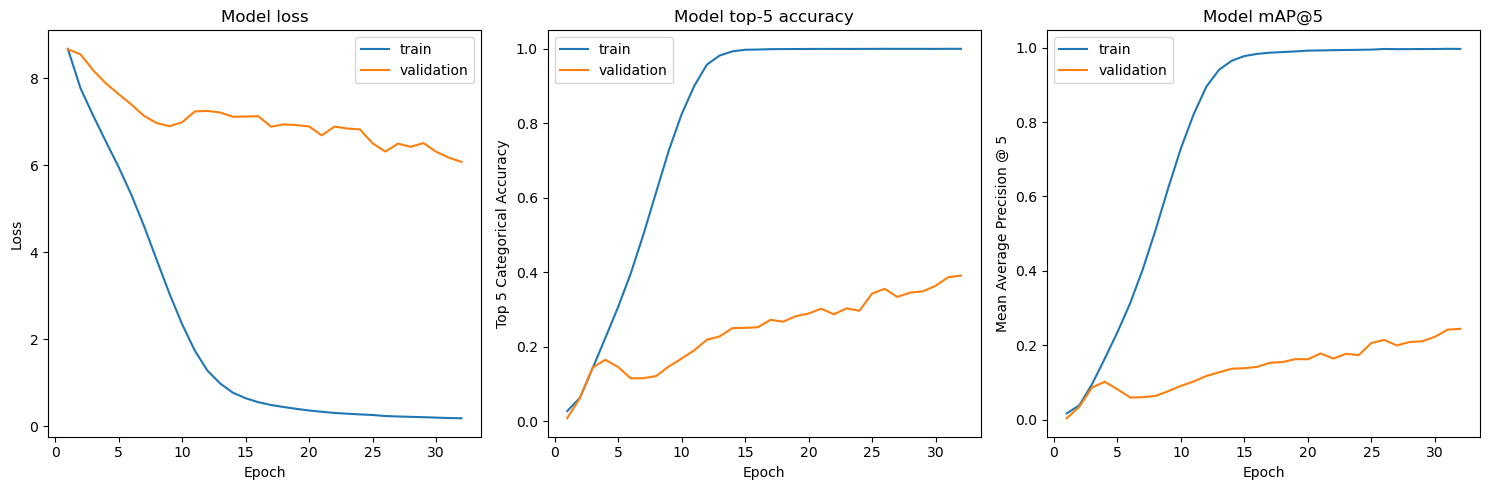

In [47]:
epochs = np.arange(1, len(history["loss"]) + 1, 1)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(epochs, history["loss"], label="train")
axs[0].plot(epochs, history["val_loss"], label="validation")
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].plot(epochs, history["top_k_categorical_accuracy"], label="train")
axs[1].plot(epochs, history["val_top_k_categorical_accuracy"], label="validation")
axs[1].set_title('Model top-5 accuracy')
axs[1].set_ylabel('Top 5 Categorical Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

axs[2].plot(epochs, history["mAP_5"], label="train")
axs[2].plot(epochs, history["val_mAP_5"], label="validation")
axs[2].set_title('Model mAP@5')
axs[2].set_ylabel('Mean Average Precision @ 5')
axs[2].set_xlabel('Epoch')
axs[2].legend()

plt.tight_layout()
plt.show()

Following the procedure outlined in the Keras guide for transfer-learning and fine-tuning, I proceed with unfreezing all of the base model and train the model end-to-end with low learning rate. 

In [48]:
# unfreeze model
model1.trainable = True

# low lr on unfreeze model
model1.compile(optimizer=tf.keras.optimizers.Adam(2e-5), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['top_k_categorical_accuracy', mAP_5])

In [49]:
history2 = model1.fit(batchedset_train,
                      batch_size=BATCH_SIZE,
                      epochs=96,
                      validation_data=batchedset_val,
                     ).history

Epoch 1/96
1346/1346 [==============================] - 732s 532ms/step - loss: 1.6456 - top_k_categorical_accuracy: 0.8557 - mAP_5: 0.7487 - val_loss: 6.0008 - val_top_k_categorical_accuracy: 0.4221 - val_mAP_5: 0.2700
Epoch 2/96
1346/1346 [==============================] - 707s 525ms/step - loss: 0.6100 - top_k_categorical_accuracy: 0.9812 - mAP_5: 0.9232 - val_loss: 5.1288 - val_top_k_categorical_accuracy: 0.5156 - val_mAP_5: 0.3393
Epoch 3/96
1346/1346 [==============================] - 715s 531ms/step - loss: 0.4079 - top_k_categorical_accuracy: 0.9946 - mAP_5: 0.9637 - val_loss: 4.8706 - val_top_k_categorical_accuracy: 0.5658 - val_mAP_5: 0.3907
Epoch 4/96
1346/1346 [==============================] - 713s 530ms/step - loss: 0.3304 - top_k_categorical_accuracy: 0.9983 - mAP_5: 0.9788 - val_loss: 4.6968 - val_top_k_categorical_accuracy: 0.5735 - val_mAP_5: 0.3997
Epoch 5/96
1346/1346 [==============================] - 712s 529ms/step - loss: 0.2918 - top_k_categorical_accuracy: 0.9

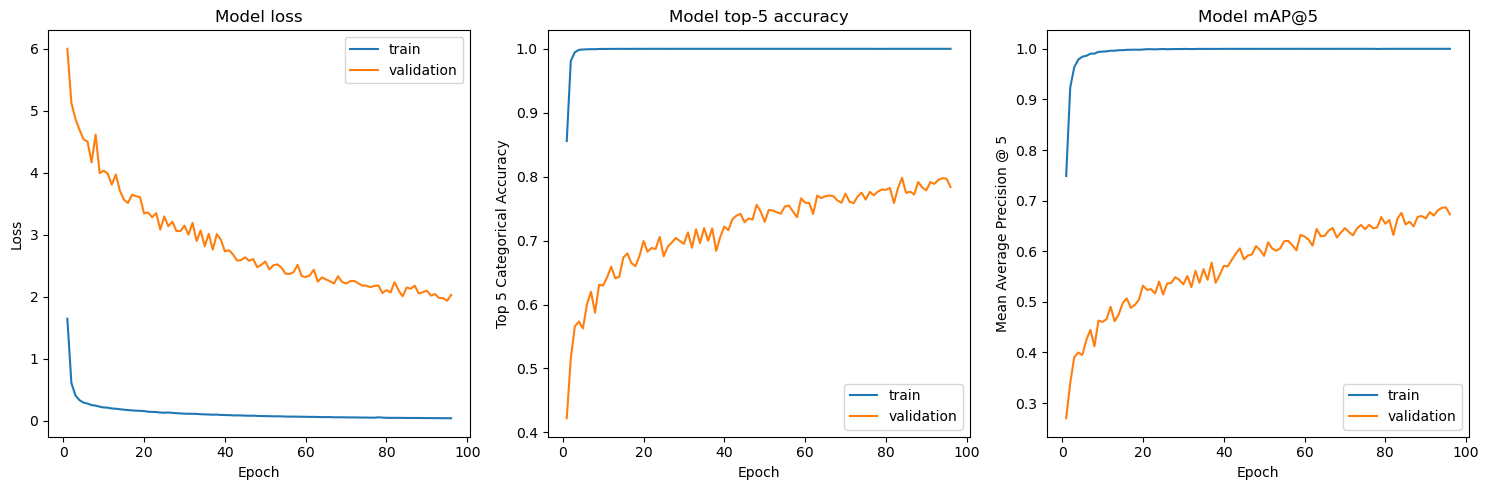

In [50]:
epochs = np.arange(1, len(history2["loss"]) + 1, 1)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(epochs, history2["loss"], label="train")
axs[0].plot(epochs, history2["val_loss"], label="validation")
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].plot(epochs, history2["top_k_categorical_accuracy"], label="train")
axs[1].plot(epochs, history2["val_top_k_categorical_accuracy"], label="validation")
axs[1].set_title('Model top-5 accuracy')
axs[1].set_ylabel('Top 5 Categorical Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

axs[2].plot(epochs, history2["mAP_5"], label="train")
axs[2].plot(epochs, history2["val_mAP_5"], label="validation")
axs[2].set_title('Model mAP@5')
axs[2].set_ylabel('Mean Average Precision @ 5')
axs[2].set_xlabel('Epoch')
axs[2].legend()

plt.tight_layout()
plt.show()

In [51]:
# Save the model
model1.save("model_01_centerLoss.h5")

#### - Preparing submission 01: using classification model and `new_whale` threshold
- Determining the logits threshold for the `new_whale` category based on its distribution

In [52]:
new_whale_df = pd.read_csv("data/my_new_whale.csv")

In [53]:
new_whale_filenames, new_whale_classes = list(), list()
for f in new_whale_df["Image"]:
    new_whale_filenames.append("data/resized_train/%s" %(f))
    new_whale_classes.append(0)

X_new = tf.data.Dataset.from_tensor_slices((new_whale_filenames))
y_new = tf.data.Dataset.from_tensor_slices((new_whale_classes))

In [54]:
X_new = X_new.map(preprocess_image)
y_new = y_new.map(preprocess_label)

In [55]:
BATCH_SIZE = 1

dataset_new = tf.data.Dataset.zip((tf.data.Dataset.zip((X_new, y_new)), y_new))
batchedset_new = dataset_new.batch(BATCH_SIZE)

In [56]:
X_ = batchedset_new.take(-1)

In [57]:
logits= model1.predict(X_)
logits_max = logits.max(axis = -1)

9664/9664 [==============================] - 246s 25ms/step


In [58]:
train_filenames, train_classes = list(), list()
for i, yi in enumerate(enc.transform(np.array(train_df["Id"].values.reshape(-1,1)) )):
    train_filenames.append("data/resized_train/%s" %(train_df["Image"][i]))
    train_classes.append(int(yi[0]))

X_train = tf.data.Dataset.from_tensor_slices((train_filenames))
y_train = tf.data.Dataset.from_tensor_slices((train_classes))

In [59]:
val_filenames, val_classes = list(), list()
for i, yi in enumerate(enc.transform(np.array(val_df["Id"].values.reshape(-1,1)) )):
    val_filenames.append("data/resized_train/%s" %(val_df["Image"][i]))
    val_classes.append(int(yi[0]))

X_val = tf.data.Dataset.from_tensor_slices((val_filenames))
y_val = tf.data.Dataset.from_tensor_slices((val_classes))

In [60]:
X_train = X_train.map(preprocess_image)
y_train = y_train.map(preprocess_label)

X_val = X_val.map(preprocess_image)
y_val = y_val.map(preprocess_label)

In [61]:
BATCH_SIZE = 1

dataset_train = tf.data.Dataset.zip((tf.data.Dataset.zip((X_train, y_train)), y_train))
dataset_val = tf.data.Dataset.zip((tf.data.Dataset.zip((X_val, y_val)), y_val))

batchedset_train = dataset_train.batch(BATCH_SIZE)
batchedset_val = dataset_val.batch(BATCH_SIZE)

In [62]:
X_ = batchedset_train.take(-1)
logits_train= model1.predict(X_)
logits_train_max = logits_train.max(axis = -1)

21525/21525 [==============================] - 552s 26ms/step


In [63]:
X_ = batchedset_val.take(-1)
logits_val= model1.predict(X_)
logits_val_max = logits_val.max(axis = -1)

2471/2471 [==============================] - 62s 25ms/step


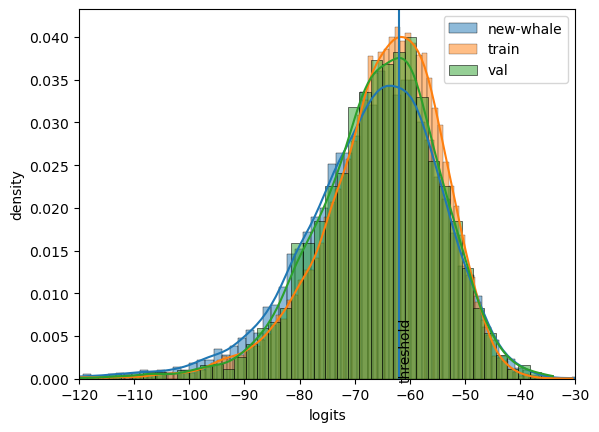

In [67]:
sns.histplot(logits_max, stat="density", kde=True, label="new-whale")
sns.histplot(logits_train_max, stat="density", kde=True, label="train")
sns.histplot(logits_val_max, stat="density", kde=True, label="val")
plt.xlabel("logits")
plt.ylabel("density")
plt.xlim([-120, -30])
plt.axvline(-63)
plt.text(-63, 0, "threshold", rotation=90)
plt.legend()
plt.show()

Conclusion: The distributions of logits for `new_whale` and known whale IDs exhibit significant overlap, indicating that there is not much separation between the two categories. This lack of distinction makes it challenging to identify an optimal threshold for classification. Given this situation, we will set the threshold at -63 as a starting point for categorizing instances as `new_whale`. 

In [68]:
NEW_WHALE_THRESHOLD = -63

- Running predictions

The approach utilizes the five highest logits to designate the whale ID. If the fifth logit falls below the threshold for `new_whale`, then the fifth ID is classified as `new_whale`. However, this method has a significant drawback: it restricts `new_whale` to only occupy the fifth position, which can yield a maximum score of 0.2 for that instance. In reality, `new_whale` could potentially be the top prediction, which is not accounted for in this approach. This limitation may lead to an underestimation of the model's performance in scenarios where `new_whale` should be prioritized over other IDs.

In [69]:
test_df = pd.read_csv("data/sample_submission.csv")
test_df.drop("Id", axis=1, inplace=True)

In [70]:
test_filenames, test_classes = list(), list()
for f in test_df["Image"]:
    test_filenames.append("data/resized_test/%s" %(f))
    test_classes.append(0)

X_test = tf.data.Dataset.from_tensor_slices((test_filenames))
y_test = tf.data.Dataset.from_tensor_slices((test_classes))

In [71]:
X_test = X_test.map(preprocess_image)
y_test = y_test.map(preprocess_label)

In [72]:
BATCH_SIZE = 1

dataset_test = tf.data.Dataset.zip((tf.data.Dataset.zip((X_test, y_test)), y_test))
batchedset_test = dataset_test.batch(BATCH_SIZE)

In [73]:
X_ = batchedset_test.take(-1)

In [74]:
logits= model1.predict(X_)

7960/7960 [==============================] - 203s 25ms/step


In [75]:
classes = np.argsort(-logits, axis = -1) #-logits is to sort descendingly

In [76]:
ans_ids = list()
for i in range(len(test_df)):
    c5 = classes[i][:5].reshape(5,1)
    lbl5 = enc.inverse_transform(c5)
    lbl5 = list(lbl5.reshape(5,))
    if logits[i][c5[4][0]] < NEW_WHALE_THRESHOLD: # the fifth logit is less than NEW_WHALE_THRESHOLD
        lbl5[4] = "new_whale"
    ans_ids.append(" ".join(lbl5))

In [77]:
test_df1 = test_df.copy()
test_df1["Id"]= ans_ids
test_df1.to_csv("submission__Resnet50_Classification_CenterLoss.csv",index=False)

### Model_2: Embedding Distance Analysis

#### - Preparing submission 02: using the output of the embeddings layer in the classification model

Sort the distances between the embeddings of instances in the test set and all instances in the training set to identify the 5 least distant Ids. This approach can help improve the classification based on their embeddings.

![title](Embedding_Distance_Analysis.png)


In [78]:
emb_output = model1.get_layer("Embeddings").output
model1_emb = models.Model(inputs = model1.input, outputs = emb_output, name="EmbeddingsFromCenterLoss")
print(model1_emb.summary())

Model: "EmbeddingsFromCenterLoss"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 2048  8192       ['resnet50[0][0]']               
 alization)                     )                                          

In [79]:
train_df = pd.read_csv("data/train.csv")

In [82]:
enc = OrdinalEncoder()
enc.fit(np.array(train_df["Id"].values).reshape(-1,1))
print ("Number of distinct Id (incl. new_whale): ", len(enc.categories_[0]))

Number of distinct Id (incl. new_whale):  5005


In [83]:
train_filenames, train_classes = list(), list()
for i, yi in enumerate(enc.transform(np.array(train_df["Id"].values.reshape(-1,1)) )):
    train_filenames.append("data/resized_train/%s" %(train_df["Image"][i]))
    train_classes.append(int(yi[0]))

X_train = tf.data.Dataset.from_tensor_slices((train_filenames))
y_train = tf.data.Dataset.from_tensor_slices(([0]*len(train_filenames)))

In [84]:
X_train = X_train.map(preprocess_image)
y_train = y_train.map(preprocess_label)

In [85]:
BATCH_SIZE = 1

dataset_train = tf.data.Dataset.zip((tf.data.Dataset.zip((X_train, y_train)), y_train))
dataset_test = tf.data.Dataset.zip((tf.data.Dataset.zip((X_test, y_test)), y_test))

batchedset_train = dataset_train.batch(BATCH_SIZE)
batchedset_test = dataset_test.batch(BATCH_SIZE)

In [86]:
X_ = batchedset_train.take(-1)

In [87]:
emb = model1_emb.predict(X_)

25361/25361 [==============================] - 528s 21ms/step


In [88]:
X_ = batchedset_test.take(-1)
emb_test = model1_emb.predict(X_)

7960/7960 [==============================] - 169s 21ms/step


In [89]:
ans_ids = list()
for i in range(len(test_df)):
    x = np.expand_dims(emb_test[i], axis=0)
    dist = np.mean(np.square(x-emb), axis= -1)
    ids = np.argsort(dist) # least distant first

    classes5, chk, k = list(), set(), 0
    while len(chk)<5:
        if train_classes[ids[k]] not in chk:
            classes5.append(train_classes[ids[k]])
            chk.add(train_classes[ids[k]])
        k+=1

    classes5 = np.expand_dims(np.array(classes5), -1)
    lbl5 = enc.inverse_transform(classes5)
    lbl5 = list(np.squeeze(lbl5))
    ans_ids.append(" ".join(lbl5))

In [90]:
test_df1 = test_df.copy()
test_df1["Id"]= ans_ids
test_df1.to_csv("submission__Resnet50_Embedding_CenterLoss.csv",index=False)

### Model_3: Triplet Loss for Improved Model Verification

I am using `tfa.losses.TripletSemiHardLoss` from tensorflow-addons. and following the tutorial on performing online triplet mining:
* https://www.tensorflow.org/addons/tutorials/losses_triplet

This approach automatically selects anchor, negative, and positive points within each minibatch and calculates the triplet semi-hard loss. From EDA we know that over 2,000 whales are represented by only one image. If the batches were picked randomly, it is very likely that there is no positive points within a batch. Therefore, we rearrange the train-set and val-set to contain anchor, negative, and positive points within each batch. I plan to set the BATCH_SIZE to multiples of 8. Consequently, I will rearrange my training and validation datasets to facilitate this structure, ensuring that each batch is composed of the appropriate points for effective training. This arrangement will help improve the model's ability to learn meaningful embeddings and enhance overall performance.

![title](Triplet_Loss.png)

#### - Rearranging the training and validation datasets into batches of 8 for triplet-loss training

In [91]:
K = 8

In [92]:
df_train = pd.read_csv("data/my_train.csv")

In [93]:
# df_train

id2files, count2ids = defaultdict(set), defaultdict(set)
N = len(df_train)

for _, row in df_train.iterrows():
    id2files[row["Id"]].add(row["Image"])

for id, files in id2files.items():
    count2ids[len(files)].add(id)

For each batch, I will select two random images from an ID if that particular ID has more than three images available. However, if the ID has three or fewer images, I will include all of the images belonging to that ID in the batch. This strategy ensures that we maintain a sufficient representation of IDs with limited samples while still allowing for variability in IDs that have more abundant data. This approach will help create balanced batches for training, facilitating effective learning of the model.

In [94]:
import random
def batching_tripletLoss(N, K, count2ids, id2files):
    M = 1+ N//K
    batches = [[] for _ in range(M)]
    
    i, k = 0, 0
    while k<N:
        lowestCount = min(count2ids.keys())
        pick = lowestCount
        if lowestCount > 3:
            pick = 2
        # print(k, i, lowestCount, len(count2ids[lowestCount]) )
        id = random.choice(list(count2ids[lowestCount]))
        for f in random.sample(list(id2files[id]), k=pick):
            while len(batches[i])>=K:
                i += 1
                if i == M:
                    i = 0
            batches[i].append((f, id))
            k += 1
            id2files[id].remove(f)
        #
        count2ids[lowestCount].remove(id)
        if len(count2ids[lowestCount]) == 0: del count2ids[lowestCount]
        if len(id2files[id]) == 0:
            del id2files[id]
        else:
            count2ids[len(id2files[id])].add(id)

        i += 1
        if i == M:
            i = 0

    return batches

In [95]:
batches = batching_tripletLoss(N, K, count2ids, id2files)
Images, Ids = list(), list()
M = 1+ N//K
idx = list(range(M))
random.shuffle(idx)
for i in idx:
    for f, id in batches[i]:
        Images.append(f)
        Ids.append(id)
df_batches = pd.DataFrame({"Image": Images, "Id": Ids})
df_batches.to_csv("data/my_train3loss.csv", index=False)

In [96]:
# df_val
df_val = pd.read_csv("data/my_val.csv")

id2files, count2ids = defaultdict(set), defaultdict(set)
N = len(df_val)

for _, row in df_val.iterrows():
    id2files[row["Id"]].add(row["Image"])

for id, files in id2files.items():
    count2ids[len(files)].add(id)

In [97]:
batches = batching_tripletLoss(N, K, count2ids, id2files)
Images, Ids = list(), list()
M = 1+ N//K
idx = list(range(M))
random.shuffle(idx)
for i in idx:
    for f, id in batches[i]:
        Images.append(f)
        Ids.append(id)
df_batches = pd.DataFrame({"Image": Images, "Id": Ids})
df_batches.to_csv("data/my_val3loss.csv", index=False)

#### - Model training using tripet-semihard-loss

In [98]:
import tensorflow_addons as tfa

In [99]:
train_df = pd.read_csv("data/my_train3loss.csv")
val_df = pd.read_csv("data/my_val3loss.csv")

In [100]:
enc = OrdinalEncoder()
enc.fit(np.array(train_df["Id"].values).reshape(-1,1))
NUM_CLASSES = len(enc.categories_[0])
print ("Number of distinct Id: ", NUM_CLASSES)

Number of distinct Id:  5004


In [101]:
train_filenames, train_classes = list(), list()
for i, yi in enumerate(enc.transform(np.array(train_df["Id"].values.reshape(-1,1)) )):
    train_filenames.append("data/resized_train/%s" %(train_df["Image"][i]))
    train_classes.append(int(yi[0]))
print(train_classes[0:16])

X_train = tf.data.Dataset.from_tensor_slices((train_filenames))
y_train = tf.data.Dataset.from_tensor_slices((train_classes))

[2542, 2542, 4490, 4490, 1909, 1909, 163, 163, 4000, 4000, 3113, 3113, 715, 715, 3866, 3866]


In [102]:
val_filenames, val_classes = list(), list()
for i, yi in enumerate(enc.transform(np.array(val_df["Id"].values.reshape(-1,1)) )):
    val_filenames.append("data/resized_train/%s" %(val_df["Image"][i]))
    val_classes.append(int(yi[0]))
print(val_classes[0:16])

X_val = tf.data.Dataset.from_tensor_slices((val_filenames))
y_val = tf.data.Dataset.from_tensor_slices((val_classes))

[2703, 2703, 1835, 1835, 1817, 1817, 1210, 1210, 4499, 4499, 2134, 2134, 384, 384, 4712, 4712]


In [103]:
X_train = X_train.map(preprocess_image)
X_val = X_val.map(preprocess_image)

In [104]:
def create_model():
    # Load the resnet50 model without the top layer
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Freeze the base model
    
    # Create the model
    input_images = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(input_images)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)  # Dropout for regularization    
    x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Activation('relu')(x)
    emb = layers.Dense(512, activation=None, name="Embeddings")(x)  # Embeddings
    emb = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(emb)

    model = models.Model(inputs=input_images, outputs=emb)
    
    # Compile the model
    # use high lr on frozen model
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss=tfa.losses.TripletSemiHardLoss(margin=0.5, distance_metric="angular"))

    return model

model2 = create_model()
print(model2.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 2048)     8192      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 2048)      0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              209817

In [105]:
BATCH_SIZE = 16

dataset_train = tf.data.Dataset.zip((X_train, y_train))
dataset_val = tf.data.Dataset.zip((X_val, y_val))

batchedset_train = dataset_train.batch(BATCH_SIZE)
batchedset_val = dataset_val.batch(BATCH_SIZE)


In [106]:
history = model2.fit(batchedset_train,
                     batch_size=BATCH_SIZE,
                     epochs=32,
                     validation_data=batchedset_val,
                    ).history

Epoch 1/32
1346/1346 [==============================] - 249s 178ms/step - loss: 0.3031 - val_loss: 0.3360
Epoch 2/32
1346/1346 [==============================] - 233s 173ms/step - loss: 0.2428 - val_loss: 0.3237
Epoch 3/32
1346/1346 [==============================] - 234s 174ms/step - loss: 0.2146 - val_loss: 0.3193
Epoch 4/32
1346/1346 [==============================] - 234s 174ms/step - loss: 0.1961 - val_loss: 0.3135
Epoch 5/32
1346/1346 [==============================] - 234s 174ms/step - loss: 0.1771 - val_loss: 0.3085
Epoch 6/32
1346/1346 [==============================] - 234s 174ms/step - loss: 0.1632 - val_loss: 0.3074
Epoch 7/32
1346/1346 [==============================] - 233s 173ms/step - loss: 0.1513 - val_loss: 0.3027
Epoch 8/32
1346/1346 [==============================] - 234s 174ms/step - loss: 0.1373 - val_loss: 0.3004
Epoch 9/32
1346/1346 [==============================] - 234s 174ms/step - loss: 0.1261 - val_loss: 0.3009
Epoch 10/32
1346/1346 [=======================

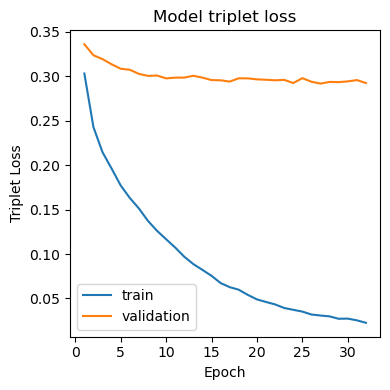

In [107]:
# Evaluate the model
# Plot the loss curves for generators and discriminators

epochs = np.arange(1, len(history["loss"]) + 1, 1)
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

axs.plot(epochs, history["loss"], label="train")
axs.plot(epochs, history["val_loss"], label="validation")
axs.set_title('Model triplet loss')
axs.set_ylabel('Triplet Loss')
axs.set_xlabel('Epoch')
axs.legend()

plt.tight_layout()
plt.show()

In [108]:
# unfreeze model
model2.trainable = True

# low lr on unfreeze model
model2.compile(optimizer=tf.keras.optimizers.Adam(2e-5), loss=tfa.losses.TripletSemiHardLoss(margin=0.5, distance_metric="angular"))

In [109]:
history2 = model2.fit(batchedset_train,
                      batch_size=BATCH_SIZE,
                      epochs=96,
                      validation_data=batchedset_val,
                     ).history

Epoch 1/96
1346/1346 [==============================] - 720s 526ms/step - loss: 0.1948 - val_loss: 0.2532
Epoch 2/96
1346/1346 [==============================] - 706s 525ms/step - loss: 0.1076 - val_loss: 0.2462
Epoch 3/96
1346/1346 [==============================] - 708s 526ms/step - loss: 0.0646 - val_loss: 0.2355
Epoch 4/96
1346/1346 [==============================] - 712s 529ms/step - loss: 0.0399 - val_loss: 0.2344
Epoch 5/96
1346/1346 [==============================] - 708s 526ms/step - loss: 0.0263 - val_loss: 0.2385
Epoch 6/96
1346/1346 [==============================] - 710s 528ms/step - loss: 0.0190 - val_loss: 0.2405
Epoch 7/96
1346/1346 [==============================] - 711s 528ms/step - loss: 0.0148 - val_loss: 0.2311
Epoch 8/96
1346/1346 [==============================] - 711s 529ms/step - loss: 0.0121 - val_loss: 0.2216
Epoch 9/96
1346/1346 [==============================] - 716s 532ms/step - loss: 0.0113 - val_loss: 0.2167
Epoch 10/96
1346/1346 [=======================

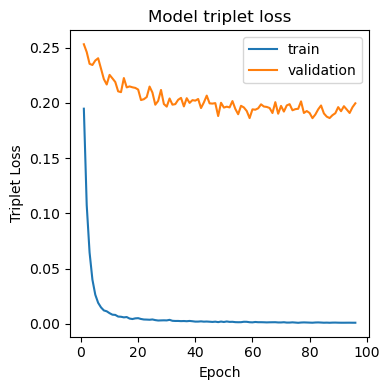

In [110]:
# Evaluate the model
# Plot the loss curves for generators and discriminators

epochs = np.arange(1, len(history2["loss"]) + 1, 1)
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

axs.plot(epochs, history2["loss"], label="train")
axs.plot(epochs, history2["val_loss"], label="validation")
axs.set_title('Model triplet loss')
axs.set_ylabel('Triplet Loss')
axs.set_xlabel('Epoch')
axs.legend()

plt.tight_layout()
plt.show()

In [111]:
# Save the model
model2.save("model_02_tripletLoss.h5")

#### - Evaluate MAP@5 on validation set

In [112]:
train_df = pd.read_csv("data/my_train3loss.csv")
new_whale_df = pd.read_csv("data/my_new_whale.csv")
train_df = pd.concat([train_df, new_whale_df], axis=0, ignore_index=True)

In [113]:
enc = OrdinalEncoder()
enc.fit(np.array(train_df["Id"].values).reshape(-1,1))
NUM_CLASSES = len(enc.categories_[0])
print ("Number of distinct Id (incl. new_whale): ", NUM_CLASSES)

Number of distinct Id (incl. new_whale):  5005


In [114]:
val_df = pd.read_csv("data/my_val3loss.csv")

In [115]:
train_filenames, train_classes = list(), list()
for i, yi in enumerate(enc.transform(np.array(train_df["Id"].values.reshape(-1,1)) )):
    train_filenames.append("data/resized_train/%s" %(train_df["Image"][i]))
    train_classes.append(int(yi[0]))

X_train = tf.data.Dataset.from_tensor_slices((train_filenames))
y_train = tf.data.Dataset.from_tensor_slices((train_classes))

In [116]:
val_filenames, val_classes = list(), list()
for i, yi in enumerate(enc.transform(np.array(val_df["Id"].values.reshape(-1,1)) )):
    val_filenames.append("data/resized_train/%s" %(val_df["Image"][i]))
    val_classes.append(int(yi[0]))

X_val = tf.data.Dataset.from_tensor_slices((val_filenames))
y_val = tf.data.Dataset.from_tensor_slices((val_classes))

In [117]:
X_train = X_train.map(preprocess_image)
X_val = X_val.map(preprocess_image)

In [118]:
BATCH_SIZE = 1

dataset_train = tf.data.Dataset.zip((X_train, y_train))
dataset_val = tf.data.Dataset.zip((X_val, y_val))

batchedset_train = dataset_train.batch(BATCH_SIZE)
batchedset_val = dataset_val.batch(BATCH_SIZE)


In [119]:
X_ = batchedset_train.take(-1)

In [120]:
emb = model2.predict(X_)

31189/31189 [==============================] - 739s 24ms/step


In [121]:
emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)

In [122]:
X_ = batchedset_val.take(-1)
emb_val = model2.predict(X_)

2471/2471 [==============================] - 58s 23ms/step


In [123]:
P = np.array([1/1, 1/2, 1/3, 1/4, 1/5])
AP = np.zeros(len(val_df))
for i in range(len(val_df)):
    x = emb_val[i]
    x = x / np.linalg.norm(x)
    sim = np.dot(emb, x)
    ids = np.argsort(sim)[::-1] # most similar first

    classes5, chk, k = list(), set(), 0
    while len(chk)<5:
        if train_classes[ids[k]] not in chk:
            classes5.append(train_classes[ids[k]])
            chk.add(train_classes[ids[k]])
        k+=1

    y_true = val_classes[i]
    y_rel = (np.array(classes5) == y_true)
    
    AP[i] = np.dot(y_rel, P)
print ("mAP@5 = ", np.mean(AP))

mAP@5 =  0.6387360043167408


#### - Preparing submission 03: using verification with tripet loss

Using the output of the Embeddings layer in the model, I sort the cosine similarity between the embeddings of instances in the test set and all instances in the training set to identify the 5 most similar Ids. 

In [124]:
train_df = pd.read_csv("data/train.csv")

In [125]:
enc = OrdinalEncoder()
enc.fit(np.array(train_df["Id"].values).reshape(-1,1))
NUM_CLASSES = len(enc.categories_[0])
print ("Number of distinct Id (incl. new_whale): ", NUM_CLASSES)

Number of distinct Id (incl. new_whale):  5005


In [126]:
test_df = pd.read_csv("data/sample_submission.csv")
test_df.drop("Id", axis=1, inplace=True)

In [127]:
train_filenames, train_classes = list(), list()
for i, yi in enumerate(enc.transform(np.array(train_df["Id"].values.reshape(-1,1)) )):
    train_filenames.append("data/resized_train/%s" %(train_df["Image"][i]))
    train_classes.append(int(yi[0]))

X_train = tf.data.Dataset.from_tensor_slices((train_filenames))
y_train = tf.data.Dataset.from_tensor_slices((train_classes))

In [128]:
test_filenames, test_classes = list(), list()
for f in test_df["Image"]:
    test_filenames.append("data/resized_test/%s" %(f))
    test_classes.append(0)

X_test = tf.data.Dataset.from_tensor_slices((test_filenames))
y_test = tf.data.Dataset.from_tensor_slices((test_classes))

In [129]:
X_train = X_train.map(preprocess_image)
X_test = X_test.map(preprocess_image)

In [130]:
BATCH_SIZE = 1

dataset_train = tf.data.Dataset.zip((X_train, y_train))
dataset_test = tf.data.Dataset.zip((X_test, y_test))

batchedset_train = dataset_train.batch(BATCH_SIZE)
batchedset_test = dataset_test.batch(BATCH_SIZE)

In [131]:
X_ = batchedset_train.take(-1)

In [132]:
emb = model2.predict(X_)

25361/25361 [==============================] - 597s 24ms/step


In [133]:
emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)

In [134]:
X_ = batchedset_test.take(-1)
emb_test = model2.predict(X_)

7960/7960 [==============================] - 193s 24ms/step


In [135]:
ans_ids = list()
for i in range(len(test_df)):
    x = emb_test[i]
    x = x / np.linalg.norm(x)
    sim = np.dot(emb, x)
    ids = np.argsort(sim)[::-1] # most similar first

    classes5, chk, k = list(), set(), 0
    while len(chk)<5:
        if train_classes[ids[k]] not in chk:
            classes5.append(train_classes[ids[k]])
            chk.add(train_classes[ids[k]])
        k+=1

    classes5 = np.expand_dims(np.array(classes5), -1)
    lbl5 = enc.inverse_transform(classes5)
    lbl5 = list(np.squeeze(lbl5))
    ans_ids.append(" ".join(lbl5))

In [136]:
test_df1 = test_df.copy()
test_df1["Id"]= ans_ids
test_df1.to_csv("submission__Resnet50_TripletLoss.csv",index=False)

### Step 4: Results and Analysis

#### Kaggle Submission

![title](kaggle_submission.png)

#### Summary table

|Model|Train_loss|Val_loss|Val_mAP@5|test_mAP@5|
|-------|-------------|--------|--------|--------|
|Classification with Center Loss|0.0386|2.0290|0.6730|0.26519|
|Embedding Distance Analysis|-|-|-|0.45048|
|Triplet Loss for Improved Model Verification|9.1197e-04|0.1997|0.6387|0.45903|

* Model 1 (Classification with Center Loss): has a low training loss but a significantly higher validation loss. This discrepancy suggests that the model may be overfitting to the training data. While the validation mAP@5 score of 0.6730 is relatively good, the test mAP@5 score of 0.26519 is considerably lower, indicating poor generalization to unseen data and poor `new_whale` thresholding approach. This gap between validation and test performance raises concerns about the model's robustness for real-world applications.

* Model 2 (Embedding Distance Analysis): focuses on distance measures rather than traditional loss metrics. The test mAP@5 score of 0.45048 indicates that this method has a reasonable ability to rank the top 5 predictions for the test set.

* Model 3 (Triplet Loss for Improved Model Verification): utilizes Triplet Loss and calculates cosine similarity. The validation mAP@5 score of 0.6387 is competitive, demonstrating good performance in ranking predictions. Notably, the test mAP@5 score of 0.45903 is the highest among the models evaluated. This suggests that the triplet loss method is more effective in learning meaningful embeddings that capture the relationships between different classes. Overall, Model 3 appears to be the most promising approach for achieving good generalization and performance on unseen data.

* During the exploratory data analysis (EDA), we identified a duplicate image, "fb3879dc7.jpg," in the test dataset, which corresponds to the ID 'w_691f2f6' in the training dataset. Notably, all three models successfully predicted the correct ID as the top priority, demonstrating their effectiveness in recognizing duplicates and reinforcing the reliability of the model's predictions. This finding highlights the models' robustness in handling duplicate cases, contributing to their overall accuracy and performance.

### Step 5: Conclusion

This project provided a valuable hands-on experience in real-world data analysis and machine learning, particularly in the context of a challenging dataset of whale images. Although the dataset was somewhat cleaned and enriched compared to previous competitions, working with the original unprocessed images proved to be a demanding task that required significant computing power. I utilized a pretrained ResNet50 model as the base, removing the top layer and experimenting with various approaches to optimize performance.

Takeaways: The project highlighted the challenges of working with imbalanced datasets and the importance of employing data augmentation techniques to enhance model performance. Utilizing pretrained models like TensorFlow Keras proved beneficial, and different loss functions, such as Center Loss and Triplet Loss, demonstrated varying effectiveness in improving prediction accuracy. The successful identification of duplicate images underscored the models' reliability in recognizing patterns.

Future Work: Moving forward, I plan to further fine-tune the Triplet Loss model to enhance its performance on the test set. Additionally, I aim to explore new competition datasets that include not only whale flukes but also other body parts, such as dorsal fins and backs, which will present a greater challenge and provide an opportunity to expand my skills in image classification and deep learning techniques.


## References

https://github.com/HarleysZhang/kaggle_humpback_whale_identification

https://ducha-aiki.medium.com/thanks-radek-7th-place-solution-to-hwi-2019-competition-738624e4c885

https://www.ic.unicamp.br/~meidanis/PUB/IC/2019-Simoes/HWIC.pdf

https://pyimagesearch.com/2023/02/13/building-a-dataset-for-triplet-loss-with-keras-and-tensorflow/

https://github.com/omoindrot/tensorflow-triplet-loss

https://omoindrot.github.io/triplet-loss

https://github.com/m2dsupsdlclass/lectures-labs

https://archive.org/details/lfw-dataset
